In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook

# Loading the data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train_len = len(train)
print("Training dataset size = {}".format(train_len))
train.head()

Training dataset size = 891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_len = len(test)
print("Test dataset size = {}".format(test_len))
test.head()

Test dataset size = 418


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Data analysis

We are going to start by analysing the features and how they relate to the passengers survival. First, let's get a sense of the data types and ranges of values for each feature.

Numerical features:

In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Categorical features:

In [6]:
train.describe(include=np.object)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Bidois, Miss. Rosalie",male,1601,B96 B98,S
freq,1,577,7,4,644


Percentage of missing data by feature:

In [7]:
print('Training set:')
print(train.isna().sum() / len(train))

Training set:
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64


In [8]:
print('Test set:')
print(test.isna().sum() / len(test))

Test set:
PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64


Features with missing data:
- **Cabin**: ~78% of missing data; remove it.
- **Age**: Decide whether to fill the missing data or not after analysis.
- **Fare**: Very small portion of the data is missing; fill it with the median (just need a reasonable value since it won't influence the result significantly).
- **Fare**: Very small portion of the data is missing; fill it with the median (just need a reasonable value since it won't influence the result significantly).

Besides Cabin, drop the PassengerId.

In [9]:
train.drop(columns=['Cabin', 'PassengerId'], inplace=True)
test.drop(columns=['Cabin', 'PassengerId'], inplace=True)

### Age

/home/davidtvs/datascience/kaggle/Titanic/titanic-env/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


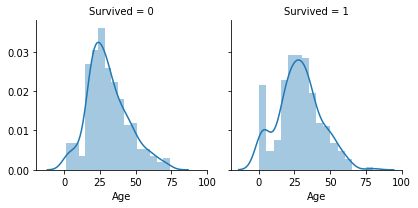

In [10]:
g = sns.FacetGrid(train, col='Survived')
_ = g.map(sns.distplot, 'Age')

In [11]:
bins = 10
age = train[['Survived', 'Age']].dropna()
age_band_series, age_bins = pd.cut(age['Age'], bins, retbins=True)

survival = (age['Survived'].groupby(age_band_series)
                           .agg(['count', 'sum', 'mean'])
                           .reset_index()
                           .rename(columns={'count': 'Total', 'sum': 'Survived', 'mean': 'Survival Rate'}))

survival

,Age,Total,Survived,Survival Rate
0,"(0.34, 8.378]",54,36,0.666667
1,"(8.378, 16.336]",46,19,0.413043
2,"(16.336, 24.294]",177,63,0.355932
3,"(24.294, 32.252]",169,65,0.384615
4,"(32.252, 40.21]",118,52,0.440678
5,"(40.21, 48.168]",70,24,0.342857
6,"(48.168, 56.126]",45,21,0.466667
7,"(56.126, 64.084]",24,9,0.375000
8,"(64.084, 72.042]",9,0,0.000000
9,"(72.042, 80.0]",2,1,0.500000


Children (age < 8) have much higher chances of survival. There are also small spikes in survival for passengers in the following bands:
- (32.252, 40.21] - 44.1%
- (48.168, 56.126] - 46.7%

### Filing missing Age values

Use Pclass and Title to fill the missing age values.

In [12]:
# Use both the training and test dataset to fill the missing Age values
fill_age_df = pd.concat([train, test], sort=True)[['Name', 'Age', 'Pclass', 'SibSp', 'Parch', 'Sex']]

# Use the age bins from above
fill_age_df['Age'] = pd.cut(fill_age_df['Age'], age_bins)

# Get the titles of the passengers
fill_age_df['Title'] = fill_age_df['Name'].apply(lambda x: x[x.find(', ') + 1:x.find('.') + 1])

# Now that we have the titles we can drop the names
fill_age_df.drop(columns='Name', inplace=True)

# Encode ages bins and titles in integers 
fill_age_df['Age'] = fill_age_df['Age'].cat.codes
fill_age_df['Title'] = fill_age_df['Title'].astype('category').cat.codes
fill_age_df['Sex'] = fill_age_df['Sex'].astype('category').cat.codes

fill_age_df

,Age,Pclass,SibSp,Parch,Sex,Title
0,2,3,1,0,1,12
1,4,1,1,0,0,13
2,3,3,0,0,0,9
3,4,1,1,0,0,13
4,4,3,0,0,1,12
5,-1,3,0,0,1,12
6,6,1,0,0,1,12
7,0,3,3,1,1,8
8,3,3,0,2,0,13
9,1,2,1,0,0,13


Try three basic classification models to predict the age bands for missing data:
- Logistic regression
- K-nearest neighbors
- Decision tree

In [13]:
X_train = fill_age_df.loc[fill_age_df['Age'] != -1].drop(columns='Age')
Y_train = fill_age_df['Age'].loc[fill_age_df['Age'] != -1]
X = fill_age_df.loc[fill_age_df['Age'] == -1].drop(columns='Age')
print("Training samples shape: {}".format(X_train.shape))
print("Ground-truth shape: {}".format(Y_train.shape))
print("Samples to predict: {}".format(X.shape))

Training samples shape: (1044, 5)
Ground-truth shape: (1044,)
Samples to predict: (265, 5)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression()
logreg_scores = cross_val_score(logreg, X_train, Y_train, cv=3)
print("Logistic Regression cross-validation scores: {}".format(logreg_scores))

knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_train, Y_train, cv=3)
print("KNeighbors cross-validation scores: {}".format(knn_scores))

tree = DecisionTreeClassifier()
tree_scores = cross_val_score(tree, X_train, Y_train, cv=3)
print("Tree Classifier cross-validation scores: {}".format(tree_scores))

Logistic Regression cross-validation scores: [0.29829545 0.29597701 0.30813953]
KNeighbors cross-validation scores: [0.25852273 0.27011494 0.37209302]
Tree Classifier cross-validation scores: [0.34943182 0.31896552 0.38081395]


None of the models high-accuracy, which shouldn't be a surprise given that the features we have are only really good at predicting children since they will have a title of Master or Miss.

Computing the per-class/per-age band accuracy confirm the above. It also shows that the model can make good predictions for passengers within the ages of 16 and 24. A possible explanation is that passengers within this age band are more likely to be traveling with friends or alone, therefore SibSp and Parch are 0.

Also note that 0 to 8 years old is the most important age band as discussed previously, thus having a low accuracy shouldn't be a problem as long as we have a high accuracy for that age band.

In [15]:
# Predict
tree.fit(X_train, Y_train)
Y_pred = tree.predict(X_train)

total = np.bincount(Y_train.values, minlength=10)
correct = np.bincount(Y_pred[Y_pred == Y_train.values], minlength=10)
class_acc = correct / total
pd.DataFrame({'Age band': age_band_series.cat.categories, 'Per class acc.': class_acc})

,Age band,Per class acc.
0,"(0.34, 8.378]",0.957143
1,"(8.378, 16.336]",0.274194
2,"(16.336, 24.294]",0.697080
3,"(24.294, 32.252]",0.396000
4,"(32.252, 40.21]",0.254658
5,"(40.21, 48.168]",0.361111
6,"(48.168, 56.126]",0.246154
7,"(56.126, 64.084]",0.097561
8,"(64.084, 72.042]",0.100000
9,"(72.042, 80.0]",0.000000


We can now predict the age band for passengers with missing data:

In [16]:
Y = tree.predict(X)
fill_age_df['Age'].loc[fill_age_df['Age'] == -1] = Y

# Just to make sure...these should both be 0 now
print("Number of -1 = {}".format(fill_age_df['Age'].loc[fill_age_df['Age'] == -1].sum()))
print("Number of NaN = {}".format(fill_age_df['Age'].isna().sum()))

Number of -1 = 0
Number of NaN = 0


/home/davidtvs/datascience/kaggle/Titanic/titanic-env/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Apply the integer encoded age bands to the train and test datasets.

In [17]:
train['Age'] = fill_age_df.iloc[:train_len, 0]
test['Age'] = fill_age_df.iloc[train_len:, 0]

train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,2,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,4,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,3,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,4,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,4,0,0,373450,8.0500,S
